In [8]:
import os
import tarfile
from six.moves import urllib

In [9]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH=os.path.join("datasets", "housing")
HOUSING_URL=DOWNLOAD_ROOT+"datasets/housing/housing.tgz"

In [10]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path=os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
        
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [11]:
fetch_housing_data()

In [12]:
import pandas as pd

In [13]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [14]:
housing=load_housing_data()

# `Explore the data`

In [15]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [16]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [17]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [18]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


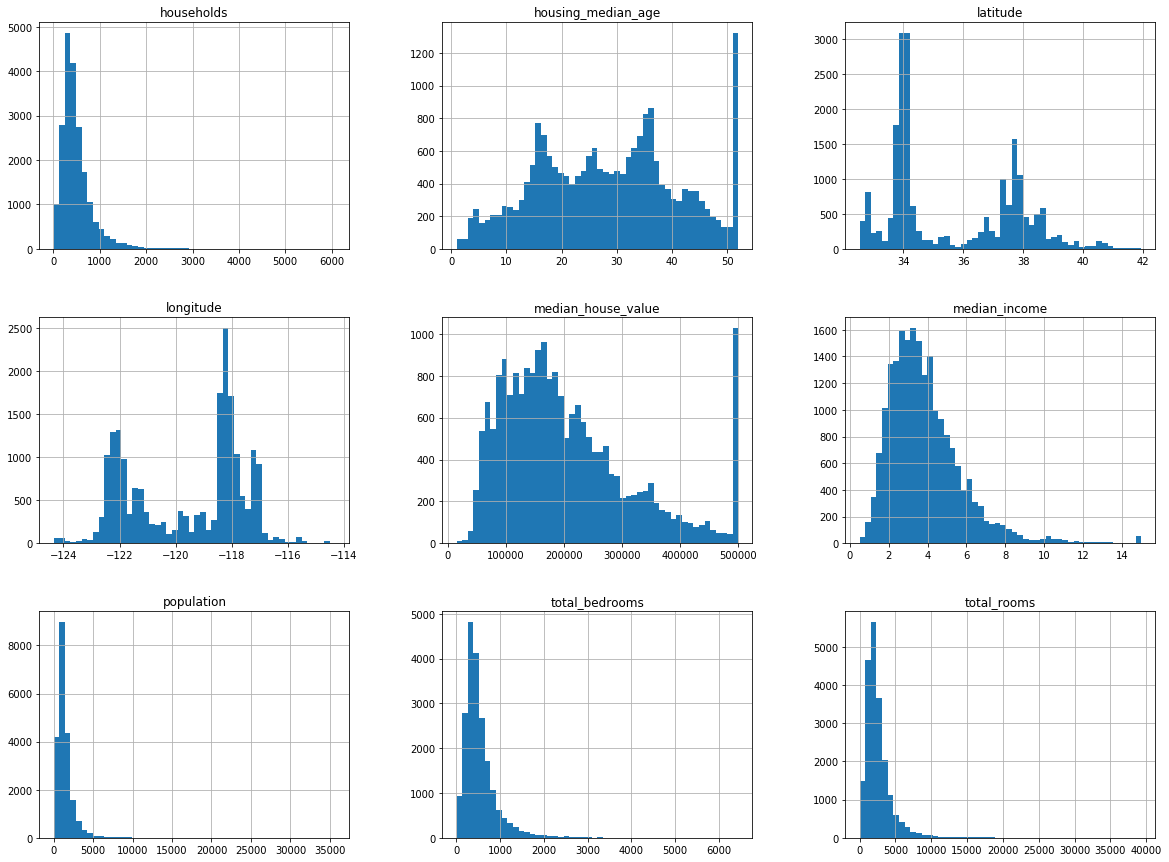

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# `Create the test set`

In [20]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [21]:
train_set, test_set = split_train_test(housing, 0.2)

In [22]:
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


**Note:** We need to avoid ever exposing test instances to the training algorithm.  So far we haven't prevented that: the function **`split_train_test`** will create a new mix of training and test instances every time it's executed.  Setting random number generator seed in the function would work if the data never gets refreshed.  If the data is refreshed and contains new instances on consequent refreshes, the following solution will keep the test instances from infiltrating the training set.  It uses hashes of the instance identifiers as the ID based on which each set is created.   

In [23]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    # compare the last byte of the identifier hash (256 possible unique vlues) 
    # with the test_ratio threshold  
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio


def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set=ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [24]:
#since our housing data doesn't have an ID column, we create it(in a new data-set):
housing_with_id = housing.reset_index()

In [25]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [26]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

This solution will work if we know for sure that as the data grows, the new data gets appended to the dataset and no rows get deleted.  If we can't be sure of that, we should use "the most stable" data attributes to synthesize the ID column as shown below:

In [27]:
housing_with_id["id"] = housing["longitude"]*1000+housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

better yet, use scikit-learn's built-in function fo splitting data-sets: **`train_test_split`**:

In [28]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## `Stratified sampling`

As we create a training set, we need to be mindful of stratum bias: it is important to have a sufficient number of instances in you dataset for each **`stratum`** or else the estimate of the stratum's importance may be biased.

In [29]:
#here we create a new 5-category attribute based on the median_incom column:
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True) #group all the outliers above cat 5 into cat 5

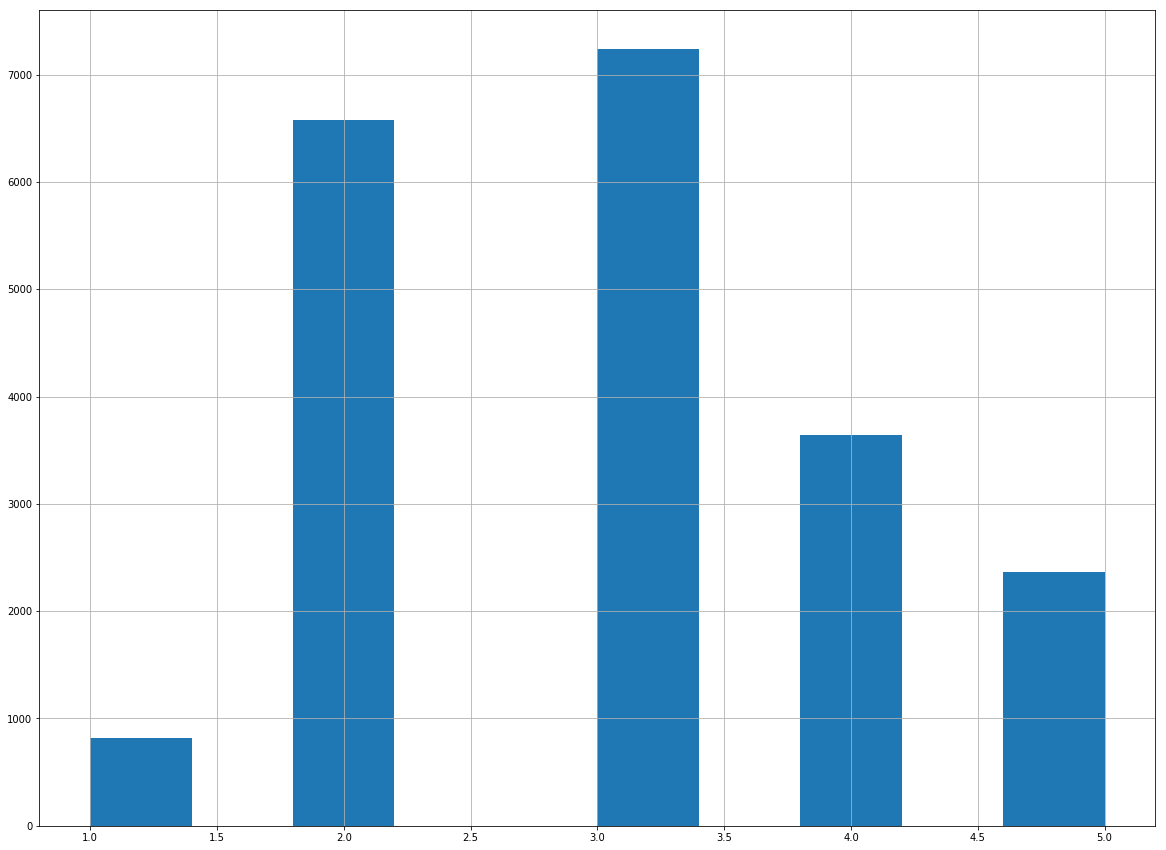

In [30]:
%matplotlib inline
housing["income_cat"].hist(figsize=(20,15))
plt.show()

...and now we can perform stratified sampling using the new column:

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [32]:
#let's look what we got:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [33]:
#for comparison:
housing["income_cat"].value_counts()/len(housing["income_cat"])

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

**Conclusion:**  the test when created with stratified sampling is almost perfectly representative of the entire set. It would not be the case if we performed purely random sampling.

In [34]:
#cleaning up: remove income_cat attribure as it's no longer needed
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

First: put the test set aside and only explore the training set.

In [35]:
# Then we create a copy of the training set for poking and prodding without harming the training set itself:
housing = strat_train_set.copy()

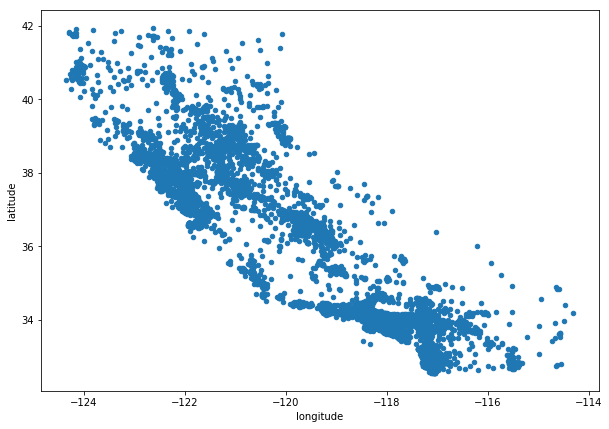

In [36]:
# Create scatterplot:
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7))
plt.show()
#setting the alpha parameter helps to vizualize density of the scatterplot

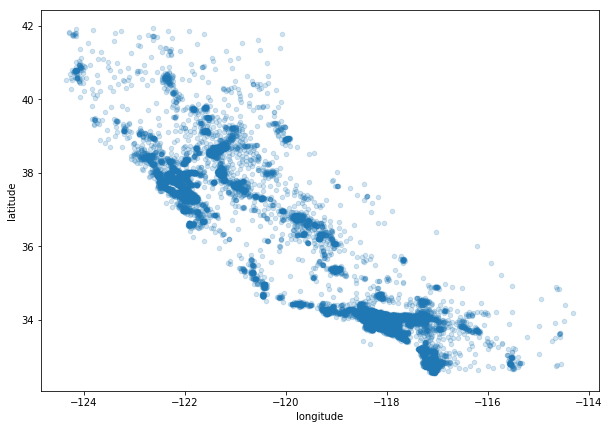

In [37]:
#Modification: set the alpha parameter
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7), alpha=0.2)
plt.show()

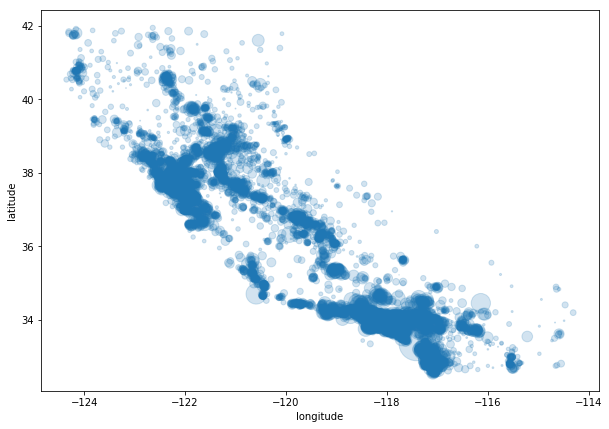

In [38]:
#Modification: set the size parameter s
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7), alpha=0.2, 
            s=housing["population"]/30)
plt.show()

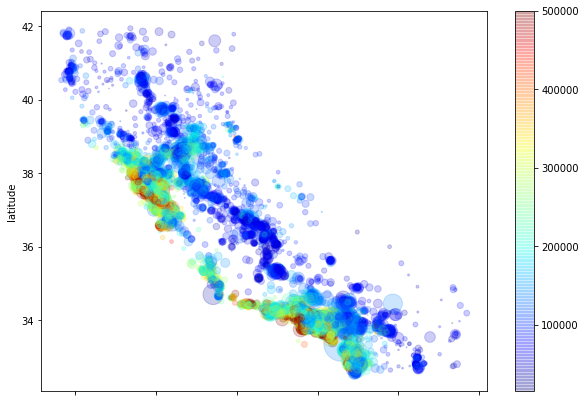

In [39]:
#Modification: set the color parameter parameter c
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7), alpha=0.2, 
            s=housing["population"]/30, c=housing["median_house_value"], 
             cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()


# Looking for correlations

In [40]:
# Use corr() to calculate standard correlation coefficient between each pair of attributes
# also called "Pearson's R":
corr_matrix = housing.corr()

In [41]:
# We are interested about each attribute's correlation with median_house_value:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

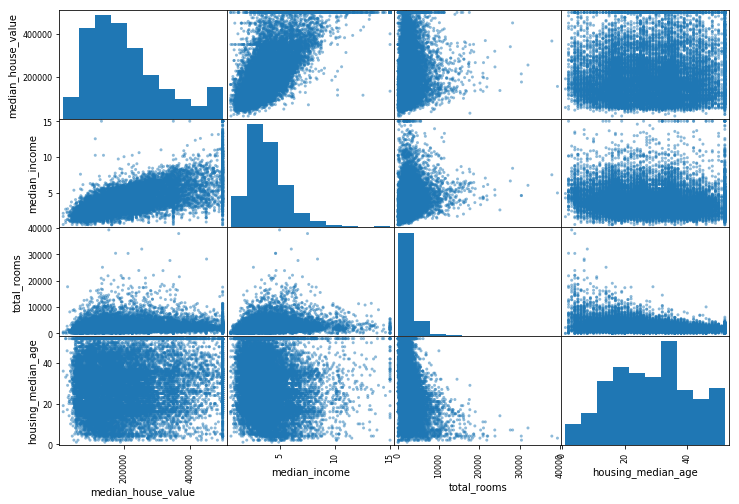

In [42]:
# We can also see these correlations as a "scatter matrix":
from pandas.plotting import scatter_matrix
attributes=["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=[12,8])
plt.show()

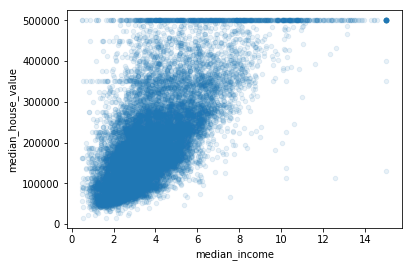

In [43]:
# Let's zoom in on the attribute with strongest correlation:
housing.plot(kind="scatter", x="median_income", 
             y="median_house_value", alpha=0.1)
plt.show()

There are horizontal lines at different price levels that can be seen on the plot.  Those are data "quirks" that we don't want the algorithms to learn to reproduce.  The ML book recommends removing the corresponding districts to avoid that. 

## Experimenting with Attribute combinations

We note that some of the attributes (like total number of rooms) are less meaningfull than their combination with other attributes (like average number of rooms per household, which is a ratio of toatl number of rooms over total number of household).  So, next we are going to create new attributes that in some ways combine the original attributes.

In [44]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [45]:
# let's look at correlations again:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

*Experimenting with Attributes combinations doesn't have to be thorough.  The goal is to quickly gain insights that will help you get a first reasonable good prototype.   Once a prototyp is up and running, you can analyze its output and come backt o this exploration step.*

# Prepare the Data for Machine Learning Algorithms

*Here we'll be writing various transformation functions -- ready for reuse and recycle*

## First, revert to a clean training set and separate predictor attributes from dependent variables (labels)

In [46]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data cleaning

In [47]:
#Different options for dealing with missing values:

#Opt. 1: delete records with missing values in the total_bedrooms column:
housing.dropna(subset=["total_bedrooms"]);


In [48]:
#Opt. 2: get rid of the entire attribute:
housing.drop("total_bedrooms", axis=1);

In [49]:
#Opt. 3: Fill in NAs with some default value (here median is used):
median = housing["total_bedrooms"].median();
housing["total_bedrooms"].fillna(median, inplace=True);

#Note:  kepp the calculated median to use it in the test set 
# and in the new data (?)

In [50]:
#The last option (imputing) can be accomplished with a Scikit's Imputer class:
from sklearn.preprocessing import Imputer
imputer=Imputer(strategy="median", axis=1)

In [51]:
# before we apply (fit) imputer object to the training data, we need to drop
# any non-numerical columns from the training set since imputer only works 
# on numbers.  Then we apply (fit) the imputer to the rest of the dataaset.
# Then we use the "trained" imputer to transform the training set 
# by replacing missing values by the "learned" medians:

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num);
X = imputer.transform(housing_num)

# at this point X is a plain Numpy array.  
# Let's put it into a Pandas DataFrame
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

## Handling Text and Categorical Attributes

ML algorithms like numbers.  OCEAN_PROXIMITY attribute is text.  First we convert it into numerical representation:

In [52]:
housing_cat=housing["ocean_proximity"]
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10];

Next, so that the ML algorithm does not think that cat = 0 is more like cat = 1 than cat = 3 (i.e. that the housing_cat attribute is ordinal), we use "One Hot encoding":

In [53]:
from sklearn.preprocessing import OneHotEncoder 
encoder = OneHotEncoder()
housing_cat_1hot=encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

In [54]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

housing_cat_1hot is a **sparse matrix:** instead of holding a bunch of zeros and a small handfull of ones, it only holds locations of ones. But if you insist on examining it as a (dense) NumPy array, use toarray() method:

In [55]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

The following **CategoricalEncoder** class is expected to become a part of SciKit-Learn shortly.  For now we define it here.  All it does is performs the transformations from text to integer to one-hot vectors in one shot:

In [57]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

Now we can perform the transformations using the **CategoricalEncoder** class define above:

In [61]:
cat_encoder=CategoricalEncoder()
housing_cat_reshaped=housing_cat.values.reshape(-1,1)
housing_cat_1hot=cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the CategoricalEncoder outputs a sparse matrix, but you can choose to encode as "onehot_dense" matrix:

In [66]:
cat_encoder=CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot=cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

## Custom transformers

This section of the book provides the "best practice" for building cusom transformer class.  Specifically, you custom class must inherit from sklearn.base.BaseEstimator and sklearn.base.TransofrmerMixin.  The section provides a sample of such a class.  This is something to look into when it's more relevant.

## Feature Scaling

ML algorithms don't perform well when the inpu umerical attributes have very different scales. Also, critically, scaling the target values is not generally required.

There are two  common methods for feature scaling: **min-max scaling** and **standartization**

Min-max scaling (normalization) shifts values into the range of 0-1. (x-min/(max-min))  *It's sensitive to outliers*.  Use Scikit-Learn's **`MinMaxScaler`** to perform it.

Standartization (x-mean/variance) doesn't bound values to a specific range, which may be a problem for some algorithms. *But it's much less effected by the outliers*  Use Scikit-Learn's **`StandardScaler`** transformer


**IMPORTANT** (verbatim form the book): As with all the transformations, it is important to **fit the scalers to the training data only** -- and not to the full dataset.  Only then can you use them to transform the training set and the test set (and new data).

## Transformation Pipelines